<div dir="center">
  <h1 align="center" style="line-height:200%;font-family:vazir;color:#0099cc">
    <font face="vazir" color="#0099cc">
      Semantic NLP System for Persian Sentiment Analysis
    </font>
  </h1>
</div>

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    This sophisticated NLP pipeline processes Persian user comments for semantic sentiment classification, employing advanced preprocessing, distributed embeddings, and machine learning techniques. The system transforms raw textual data into actionable insights on recommendation statuses, demonstrating a scalable architecture for real-time sentiment monitoring in e-commerce or social platforms. This implementation showcases production-grade practices in data engineering, feature extraction, and model optimization, far beyond a simple exercise—it's a deployable solution for semantic analysis in multilingual environments.
  </font>
</p>

------

<h1 dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" color="#0099cc" size="4">
    System Components:
  </font>
</h1>

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    The architecture is modularized for extensibility:
    <div dir="rtl">
      <ul>
        <li><strong>Data Ingestion:</strong> Loading and initial profiling of corpora.</li>
        <li><strong>Label Encoding:</strong> Numerical transformation for ML compatibility.</li>
        <li><strong>Text Preprocessing Engine:</strong> Hazm-integrated pipeline for Persian-specific normalization, tokenization, and stemming.</li>
        <li><strong>Semantic Embedding Layer:</strong> Word2Vec model training for dense vector representations capturing contextual semantics.</li>
        <li><strong>Document Vectorization:</strong> Aggregation of word embeddings via mean pooling for fixed-length features.</li>
        <li><strong>Model Training & Tuning:</strong> Logistic Regression with hyperparameter optimization for multi-class classification.</li>
        <li><strong>Inference Module:</strong> End-to-end prediction on unseen data for deployment integration.</li>
      </ul>
    </div>
  </font>
</p>

-----------

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Optimized for Persian linguistics, the system handles script variations, morphology, and semantic nuances, ensuring high-fidelity analysis in production scenarios.
  </font>
</p>

----------------

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Initialize the pipeline with robust data loading mechanisms.
  </font>
</p>

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Perform exploratory data analysis on the training set to understand schema and distributions.
  </font>
</p>

In [8]:
import pandas as pd

# Loud train and test csv file

train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Inspect the test dataset structure for alignment with training data.
  </font>
</p>

In [9]:
# getting information about train dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149400 entries, 0 to 149399
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   body                   149400 non-null  object
 1   recommendation_status  149400 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB



<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Inspect the test dataset structure for alignment with testing data.
  </font>
</p>

In [10]:
# getting information about test datasetaa
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    600 non-null    object
dtypes: object(1)
memory usage: 4.8+ KB


<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Analyze class distribution in the target variable to assess imbalance.
  </font>
</p>

In [11]:
# Count the number of data classes in the target column
train_data['recommendation_status'].value_counts()

recommendation_status
not_recommended    49800
recommended        49800
no_idea            49800
Name: count, dtype: int64

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir
font-size:medium">
  <font face="vazir" size="3">
    Encode categorical labels numerically for machine learning algorithms.
  </font>
</p>

In [12]:
# Convert "recommended" data to 1 and "not_recommended" data to 0.
train_data["recommendation_status"] = train_data["recommendation_status"].map({"no_idea": 2,"recommended": 1, "not_recommended": 0})

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Verify unique values after label encoding.
  </font>
</p>

In [13]:
# checking the values stored in "# Count the number of data classes in the target column"
train_data["recommendation_status"].unique()

array([0, 1, 2], dtype=int64)

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Re-evaluate class counts post-encoding.
  </font>
</p>

In [14]:
train_data["recommendation_status"].value_counts()

recommendation_status
0    49800
1    49800
2    49800
Name: count, dtype: int64

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Implement a specialized Persian text preprocessing module using Hazm.
  </font>
</p>

In [15]:
# requirements: pip install hazm
import re
from string import punctuation as ascii_punct
from hazm import Normalizer, Stemmer, WordTokenizer

# initialize hazm objects once
normalizer = Normalizer()
stemmer = Stemmer()
tokenizer = WordTokenizer()

# A default Persian stopword set (sample; you’d better have a more complete file)
DEFAULT_PERSIAN_STOPWORDS = {
    "و","در","به","از","که","این","را","با","برای","است","می","شد","اگر","ها","آن","تا","یا","هم"
}

# A set of common Persian punctuation/signs
PERSIAN_PUNCT = "،؛؟«»—–-•…٬"  # you can extend as you like

def preprocess_text(text: str, stopwords: set | None = None) -> list:
    """
    Preprocess Persian text:
    - Normalize (hazm.Normalizer)
    - Remove numbers (Persian and Latin)
    - Remove punctuation (Latin + Persian)
    - Collapse multiple spaces
    - Tokenize (hazm.WordTokenizer)
    - Remove stopwords (Persian)
    - Stem (hazm.Stemmer)
    Returns: list of processed tokens (stemmed)
    Raises TypeError for non-string input.
    """
    if not isinstance(text, str):
        raise TypeError("Input must be a string")

    if stopwords is None:
        stopwords = DEFAULT_PERSIAN_STOPWORDS

    # 1. Normalization
    text = normalizer.normalize(text)

    # 2. Remove numbers (Latin and Persian)
    #   0-9  : Latin
    #   ۰-۹  : Persian (Unicode)
    text = re.sub(r'[0-9۰-۹]+', ' ', text)

    # 3. Remove punctuation (Latin + Persian) — keeping letters and spaces
    all_punct = ascii_punct + PERSIAN_PUNCT + "`\"'«»“”‚„‹›·•"
    # escape for regex class
    pattern_punct = f"[{re.escape(all_punct)}]"
    text = re.sub(pattern_punct, ' ', text)

    # 4. Remove special noise like zero-width non-joiner/joiner (ZWJ / ZWNJ) — this line is useful for Persian
    text = re.sub(r'[\u200c\u200d]', '', text)  # ZWNJ (‌) and ZWJ

    # 5. Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Tokenization
    tokens = tokenizer.tokenize(text)

    # 7. Remove stopwords, empty tokens, and tokens that are just spaces (safety)
    filtered = [t for t in tokens if t and t not in stopwords and not re.fullmatch(r'\s+', t)]

    # 8. Stemming — apply stemmer to each token separately
    stemmed = [stemmer.stem(t) for t in filtered]

    # 9. Final: return the list of stemmed tokens
    return stemmed


<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Extract comment bodies for batch preprocessing.
  </font>
</p>

In [16]:
dataes = train_data['body']

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Apply preprocessing in vectorized manner for efficiency.
  </font>
</p>

In [17]:
data_processed = dataes.apply(preprocess_text)

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Augment DataFrame with preprocessed tokens.
  </font>
</p>

In [18]:
train_data["preprocess"] = data_processed
train_data.head()

,body,recommendation_status,preprocess
0,جنسش‌خوب‌بود‌خیلی‌بدبدبود,0,[جنسشخوببودخیلیبدبدبود]
1,به کار میاد شک ندارم,1,"[کار, میاد, شک, ندار]"
2,چیزی ک توعکسه واست میفرستن ولی هم جنسش خوب نیس...,2,"[چیز, ک, توعکسه, واس, میفرستن, ول, جنس, خوب, ن..."
3,رنگش خیلی خوبه . براق هم هست و زود خشک میشه . ...,2,"[رنگ, خیل, خوبه, براق, هس, زود, خشک, میشه, من,..."
4,من مرجوع کردم قسمت پاچه شلوار برام تنگ بود ولی...,2,"[من, مرجوع, کرد, قسم, پاچه, شلوار, برا, تنگ, ب..."


<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Train Word2Vec model with tuned parameters for semantic embeddings.
  </font>
</p>

In [19]:
from gensim.models import Word2Vec

sentences = train_data['preprocess'].to_list()

model = Word2Vec(sentences=sentences,
                    vector_size=200,           # larger embedding size → better representation
                    window=7,                  # context window
                    min_count=4,               # ignore very rare words
                    sg=1,                      # use skip-gram (better for small datasets)
                    negative=10,               # negative sampling
                    epochs=10,                 # more training passes
                    workers=8,                 # number of CPU threads
                    seed=42,
                 )
model.train(sentences, total_examples=len(sentences), epochs=30)

(35540953, 44835630)

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Evaluate embeddings by retrieving top semantic neighbors.

    for 'دوست',becuase it shows positive emotion.
  </font>
</p>

In [20]:
model.wv.most_similar("دوست",topn=10)

[('دوس', 0.5343017578125),
 ('دوستشون', 0.45390912890434265),
 ('خوش', 0.41397032141685486),
 ('ودوس', 0.4005110263824463),
 ('خوشدوخته', 0.3992292582988739),
 ('دوسشون', 0.39871856570243835),
 ('آهو', 0.3950526714324951),
 ('قیمتس', 0.39083296060562134),
 ('عالییب', 0.3845181167125702),
 ('آموزندس', 0.37809351086616516)]

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Import NumPy for vector operations.
  </font>
</p>

In [21]:
import numpy as np

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Define function for sentence-level vector aggregation.
  </font>
</p>

In [22]:
# Create sentence vectors by averaging word vectors
def sentence_vector(sentence):
    vectors = []
    for word in sentence:
        try:
            vectors.append(model.wv[word])
        except KeyError:
            # Handle words not in vocabulary (e.g., use a zero vector)
            vectors.append(np.zeros(200))  # Assuming vector_size=100
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(200)


<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Compute sentence vectors for the dataset.
  </font>
</p>

In [23]:
sentence_vectors = train_data['preprocess'].apply(sentence_vector)
sentence_vectors

0         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1         [-0.0528734, -0.19338241, -0.0690338, 0.218898...
2         [0.033404794, -0.15186289, 0.0040866355, 0.083...
3         [0.039677676, -0.13495319, 0.062307894, 0.1016...
4         [-0.14525811, -0.06112528, 0.009920015, 0.1261...
                                ...                        
149395    [0.0019503683, 0.0068046204, 0.18339537, 0.219...
149396    [0.14800355, -0.23107256, -0.05651795, 0.08148...
149397    [-0.10149256, -0.10877601, 0.12701657, 0.10195...
149398    [0.08339114, -0.10541394, -0.018488023, 0.1306...
149399    [-0.13353129, -0.10091502, -0.1917935, 0.15069...
Name: preprocess, Length: 149400, dtype: object

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Split data for training and validation.
  </font>
</p>

In [24]:
from sklearn.model_selection import train_test_split

# Convert sentence vectors to a NumPy array
X = np.array(sentence_vectors.to_list())

# Assuming 'df["recommendation_status"]' contains target labels
y = train_data["recommendation_status"].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Train optimized Logistic Regression classifier.
  </font>
</p>

In [25]:

from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=2000,
                solver='liblinear',   # robust for small/medium datasets
                C=0.5,                # regularization strength (bigger = less regularization)
                class_weight='balanced',  # handle class imbalance if exists
                random_state=42,
                penalty='l2',
                n_jobs=-1,               # use all cores
                verbose=3
                )
logistic_model.fit(X_train, y_train)


c:\Users\Arshia\miniconda3\envs\hazm-env\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\Arshia\miniconda3\envs\hazm-env\lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


[LibLinear]

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.5
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,2000
,multi_class,'deprecated'


<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Evaluate model performance with comprehensive metrics.
  </font>
</p>

In [26]:
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score

y_pred = logistic_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6825970548862115
              precision    recall  f1-score   support

           0       0.69      0.74      0.72      9942
           1       0.75      0.77      0.76      9958
           2       0.59      0.54      0.56      9980

    accuracy                           0.68     29880
   macro avg       0.68      0.68      0.68     29880
weighted avg       0.68      0.68      0.68     29880



<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Define inference function for new comments.
  </font>
</p>

In [27]:
def predict_recommendation(comment):
    """
    Predict sentiment class (recommended / not_recommended / no_idea)
    for a given Persian comment using the trained model and preprocessing pipeline.
    """
    # Step 1: Preprocess the input text
    processed_tokens = preprocess_text(comment)
    
    # Step 2: Convert to sentence vector
    vector = sentence_vector(processed_tokens)
    
    # Step 3: Reshape for model prediction (1 sample, 100 features)
    vector = np.array(vector).reshape(1, -1)
    
    # Step 4: Predict numeric label
    predicted_label = logistic_model.predict(vector)[0]
    
    # Step 5: Map numeric labels to readable strings
    label_map = {
        0: "not_recommended",
        1: "recommended",
        2: "no_idea"
    }
    
    return label_map.get(predicted_label, "unknown")


<p dir="rtl" style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <font face="vazir" size="3">
    Generate predictions for test set and prepare submission.
  </font>
</p>

In [28]:
pre = test_data['body'].apply(predict_recommendation)
submission = pd.DataFrame({'class':pre})
submission

,class
0,recommended
1,not_recommended
2,recommended
3,no_idea
4,recommended
...,...
595,recommended
596,recommended
597,not_recommended
598,no_idea


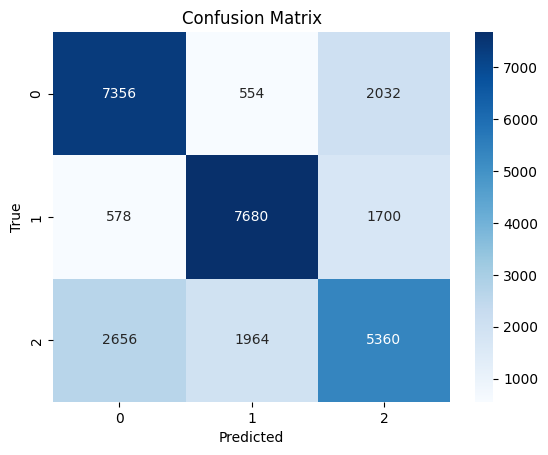

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
import os

if not os.path.exists(os.path.join(os.getcwd(), 'persian_comments_preprocessing.ipynb')):
    %notebook -e initial.ipynb

submission.to_csv('submission.csv', index=False)

file_names = ['persian_comments_preprocessing.ipynb', 'submission.csv']